In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from Graphs import create_barplot, sns_scatterplot

# Load dataset
data = pd.read_csv("ev_charging_patterns.csv")

In [2]:
# Data Preprocessing and Time Feature Extraction

data.dropna(inplace=True)

# Extracting detailed time features from Charging Start Time
# Convert Charging Start Time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Extract hour, 15-minute interval, weekday/weekend, and month from Charging Start Time
data['Hour'] = data['Charging Start Time'].dt.hour
data['Weekday'] = data['Charging Start Time'].dt.weekday
data['Is Weekend'] = data['Weekday'] >= 5
data['Weekday'] = data['Charging Start Time'].dt.day_name()
data['Month'] = data['Charging Start Time'].dt.month

# Categorize Time of Day into more specific periods
def categorize_time_of_day(hour):
    if 7 <= hour < 9:
        return "Morning Peak"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 14:
        return "Midday"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 19:
        return "Evening Peak"
    elif 19 <= hour < 23:
        return "Evening"
    else:
        return "Late Night"

data['Time of Day'] = data['Hour'].apply(categorize_time_of_day)

# Categorize Time of Day as an ordered categorical variable
time_order = ["Morning Peak", "Morning", "Midday", "Afternoon", "Evening Peak", "Evening", "Late Night"]
data['Time of Day'] = pd.Categorical(data['Time of Day'], categories=time_order, ordered=True)

# Calculate unit cost (USD per kWh) for each charging session
data['Unit Cost (USD per kWh)'] = data['Charging Cost (USD)'] / data['Energy Consumed (kWh)']

# Use MAD to detect outliers in Unit Cost
mad_cost = np.abs(data['Unit Cost (USD per kWh)'] - data['Unit Cost (USD per kWh)'].median()).median()
outliers_cost = np.abs(data['Unit Cost (USD per kWh)'] - data['Unit Cost (USD per kWh)'].median()) > 10 * mad_cost
data = data[~outliers_cost]

# Time-based Analysis

In [3]:
# 1. Peak Analysis (Time Dimension)

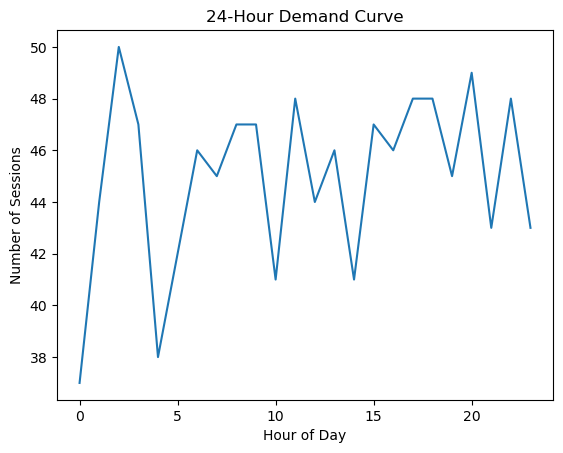

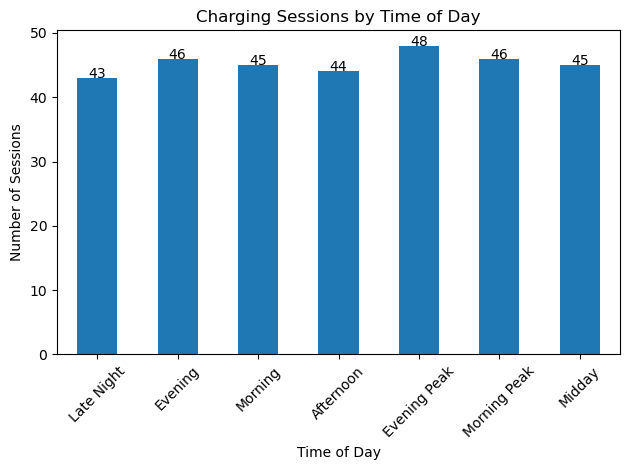

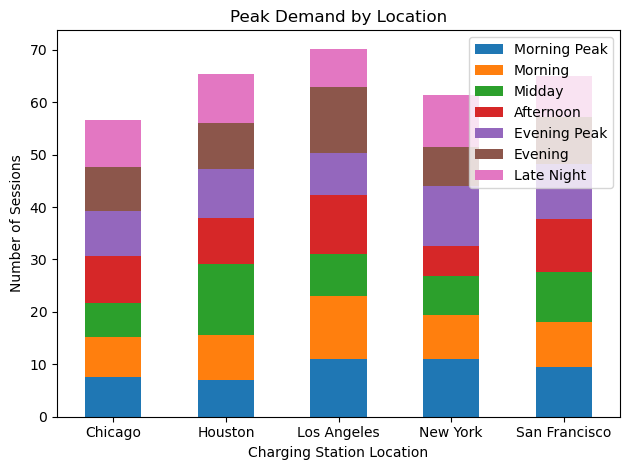

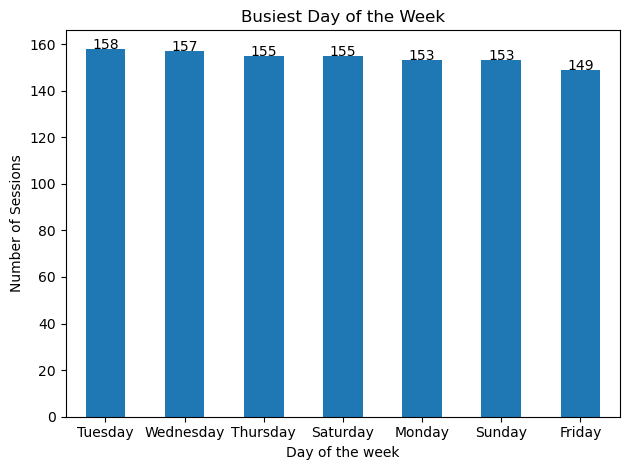

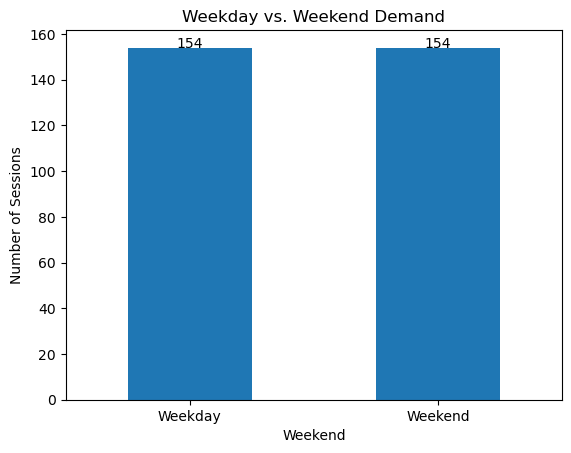

In [4]:
# 1.1 Charging Sessions Count by Time (Univariate Analysis)

# 1.1.1 Count charging sessions by hour (24-hour demand curve)
hourly_sessions = data.groupby('Hour').size()
hourly_sessions.plot(kind='line', title='24-Hour Demand Curve')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.show()

def divide_by_hours(x):
    x['Morning Peak'] = x['Morning Peak'] / 2
    x['Evening Peak'] = x['Evening Peak'] / 2
    x['Morning'] = x['Morning'] / 3
    x['Midday'] = x['Midday'] / 2
    x['Afternoon'] = x['Afternoon'] / 3
    x['Evening'] = x['Evening'] / 4
    x['Late Night'] = x['Late Night'] / 8

# 1.1.2 Count charging sessions by Time of Day
time_of_day_sessions = data['Time of Day'].value_counts()
divide_by_hours(time_of_day_sessions)
# Remove the decimal part of the values
time_of_day_sessions = time_of_day_sessions.astype(int)
create_barplot(time_of_day_sessions, 'Time of Day', 'Number of Sessions', 'Charging Sessions by Time of Day', rotation=45)

# 1.1.3 Analyzing peak demand differences by charging station location
peak_by_location = data.groupby(['Charging Station Location', 'Time of Day']).size().unstack()
divide_by_hours(peak_by_location)
create_barplot(peak_by_location, 'Charging Station Location', 'Number of Sessions', 'Peak Demand by Location', stacked=True, annotate=False, legend=True)

# 1.1.4 Find the busiest day
busiest_day = data['Weekday'].value_counts()
create_barplot(busiest_day, 'Day of the week', 'Number of Sessions', 'Busiest Day of the Week')

# 1.1.5 Compare demand between weekdays and weekends
weekday_sessions = data.groupby('Is Weekend').size()
# Divide by 5 and 2 to get average number of sessions per weekday and weekend
weekday_sessions[0] = int(weekday_sessions[0] / 5)
weekday_sessions[1] = int(weekday_sessions[1] / 2)
weekday_sessions.plot(kind='bar', title='Weekday vs. Weekend Demand')
plt.xlabel('Weekend')
plt.ylabel('Number of Sessions')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
for i, v in enumerate(weekday_sessions):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

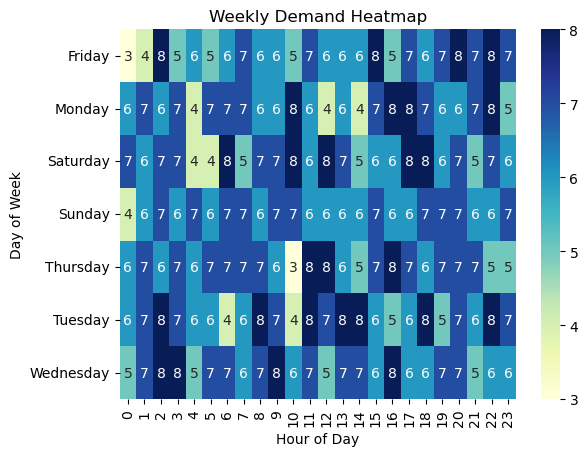

In [5]:
# 2.2 Bivariate Analysis
# Weekly demand heatmap
weekly_demand = data.pivot_table(index='Weekday', columns='Hour', values='User ID', aggfunc='count').fillna(0)
sns.heatmap(weekly_demand, cmap='YlGnBu', annot=True)
plt.title('Weekly Demand Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

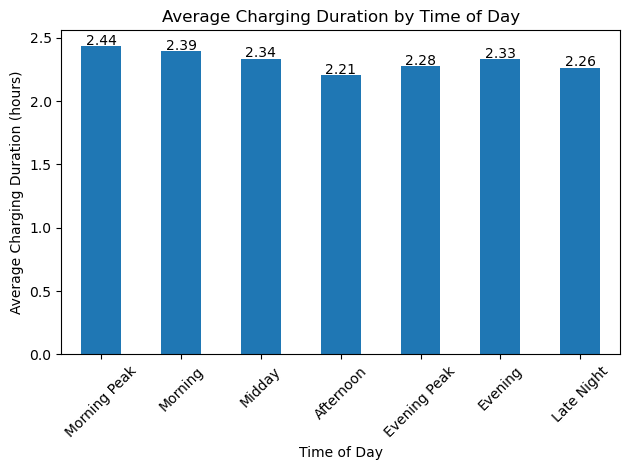

In [6]:
# 2.3 Average charging duration by Time of Day
avg_duration = data.groupby('Time of Day')['Charging Duration (hours)'].mean()
create_barplot(avg_duration, 'Time of Day', 'Average Charging Duration (hours)', 'Average Charging Duration by Time of Day', rotation=45)

In [7]:
# 3. Unit Cost Analysis

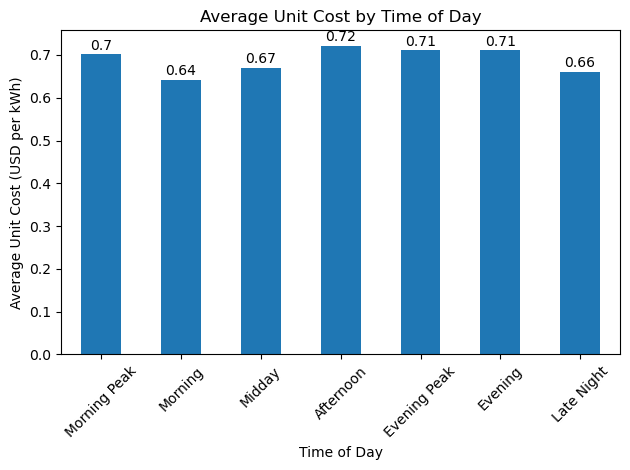

In [11]:
# 3.1 Average Unit Cost by Time of Day (show exact figures on the plot)
avg_unit_cost = data.groupby('Time of Day')['Unit Cost (USD per kWh)'].mean()
create_barplot(avg_unit_cost, 'Time of Day', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Time of Day', rotation=45)

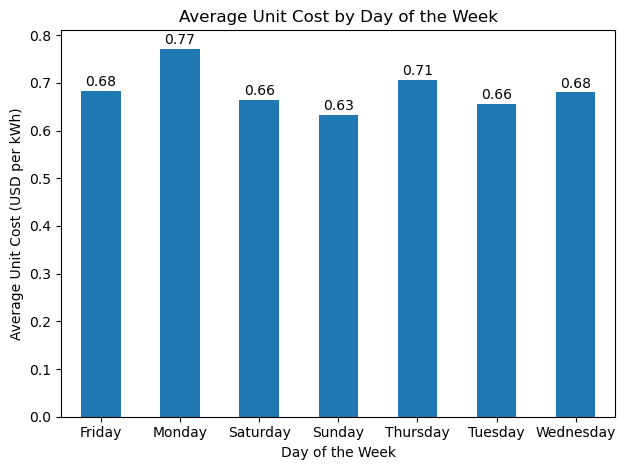

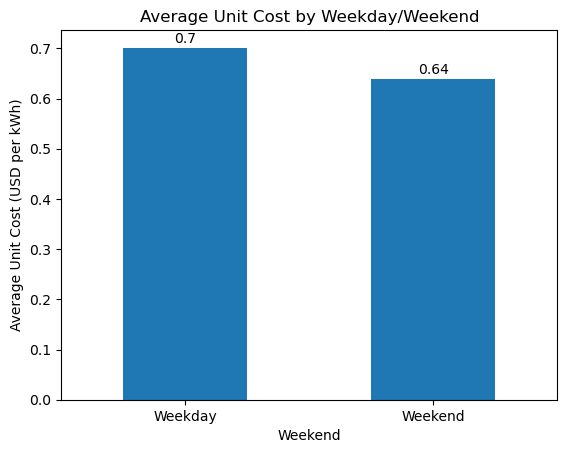

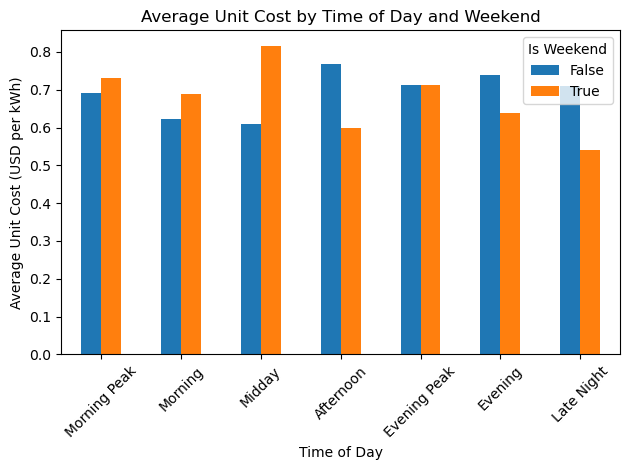

In [9]:
# 3.2 Cost Analysis by Day
# Average Unit Cost by Day of the Week
avg_unit_cost_weekday = data.groupby('Day of Week')['Unit Cost (USD per kWh)'].mean()
create_barplot(avg_unit_cost_weekday, 'Day of the Week', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Day of the Week')

# Average Unit Cost by Weekday/Weekend
avg_unit_cost_weekend = data.groupby('Is Weekend')['Unit Cost (USD per kWh)'].mean()
avg_unit_cost_weekend.plot(kind='bar', title='Average Unit Cost by Weekday/Weekend')
plt.xlabel('Weekend')
plt.ylabel('Average Unit Cost (USD per kWh)')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
for i, v in enumerate(avg_unit_cost_weekend):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# Compare average charging cost by Time of Day and between weekdays and weekends
time_costs = data.groupby(['Time of Day', 'Is Weekend'])['Unit Cost (USD per kWh)'].mean().unstack()
create_barplot(time_costs, 'Time of Day', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Time of Day and Weekend', annotate=False, rotation=45)

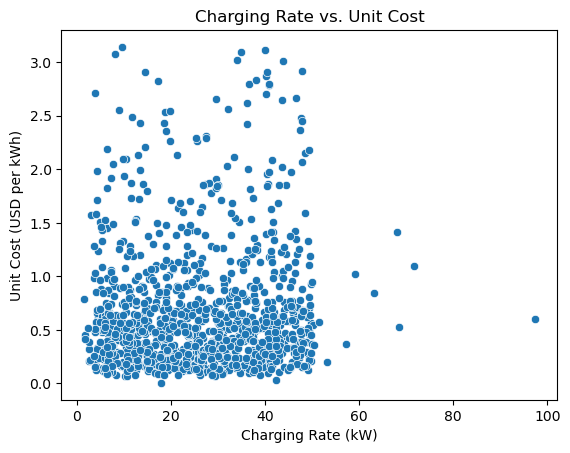

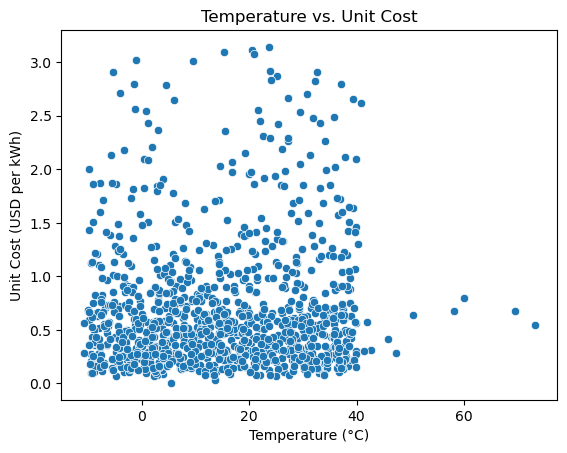

In [10]:
# 3.3 Factors Affecting Charging Costs
# Charging Rate impact on unit cost
sns_scatterplot('Charging Rate (kW)', 'Unit Cost (USD per kWh)', data, 'Charging Rate vs. Unit Cost', 'Charging Rate (kW)', 'Unit Cost (USD per kWh)')

# Temperature impact on unit cost
sns_scatterplot('Temperature (°C)', 'Unit Cost (USD per kWh)', data, 'Temperature vs. Unit Cost', 'Temperature (°C)', 'Unit Cost (USD per kWh)')